# Image Colorization using AE and VAE


## Importing Libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'
%matplotlib inline

## Loading the Data

In [335]:
def load_data(PATH):
    filenames = []
    outcomes = []

    for class_name in os.listdir(PATH):
        class_folder = os.path.join(PATH, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith('.jpg'):
                    filenames.append(os.path.join(class_folder, filename))
                    outcomes.append(class_name)

    data = pd.DataFrame({'filename': filenames, 'outcome': outcomes})
    data = data.sample(frac=1).reset_index(drop=True)

    return data


train_data = load_data('birds/train')
val_data = load_data('birds/valid')
test_data = load_data('birds/test')

print(f'Train Data Shape: {train_data.shape}')
print(f'Validation Data Shape: {val_data.shape}')
print(f'Test Data Shape: {test_data.shape}')

Train Data Shape: (3208, 2)
Validation Data Shape: (100, 2)
Test Data Shape: (100, 2)


## Plot some of the images

In [336]:
train_data.head()

filename                outcome
0  birds/train\ALTAMIRA YELLOWTHROAT\140.jpg  ALTAMIRA YELLOWTHROAT
1       birds/train\AMERICAN KESTREL\107.jpg       AMERICAN KESTREL
2        birds/train\ABBOTTS BABBLER\065.jpg        ABBOTTS BABBLER
3    birds/train\AFRICAN PYGMY GOOSE\069.jpg    AFRICAN PYGMY GOOSE
4         birds/train\ALBERTS TOWHEE\107.jpg         ALBERTS TOWHEE

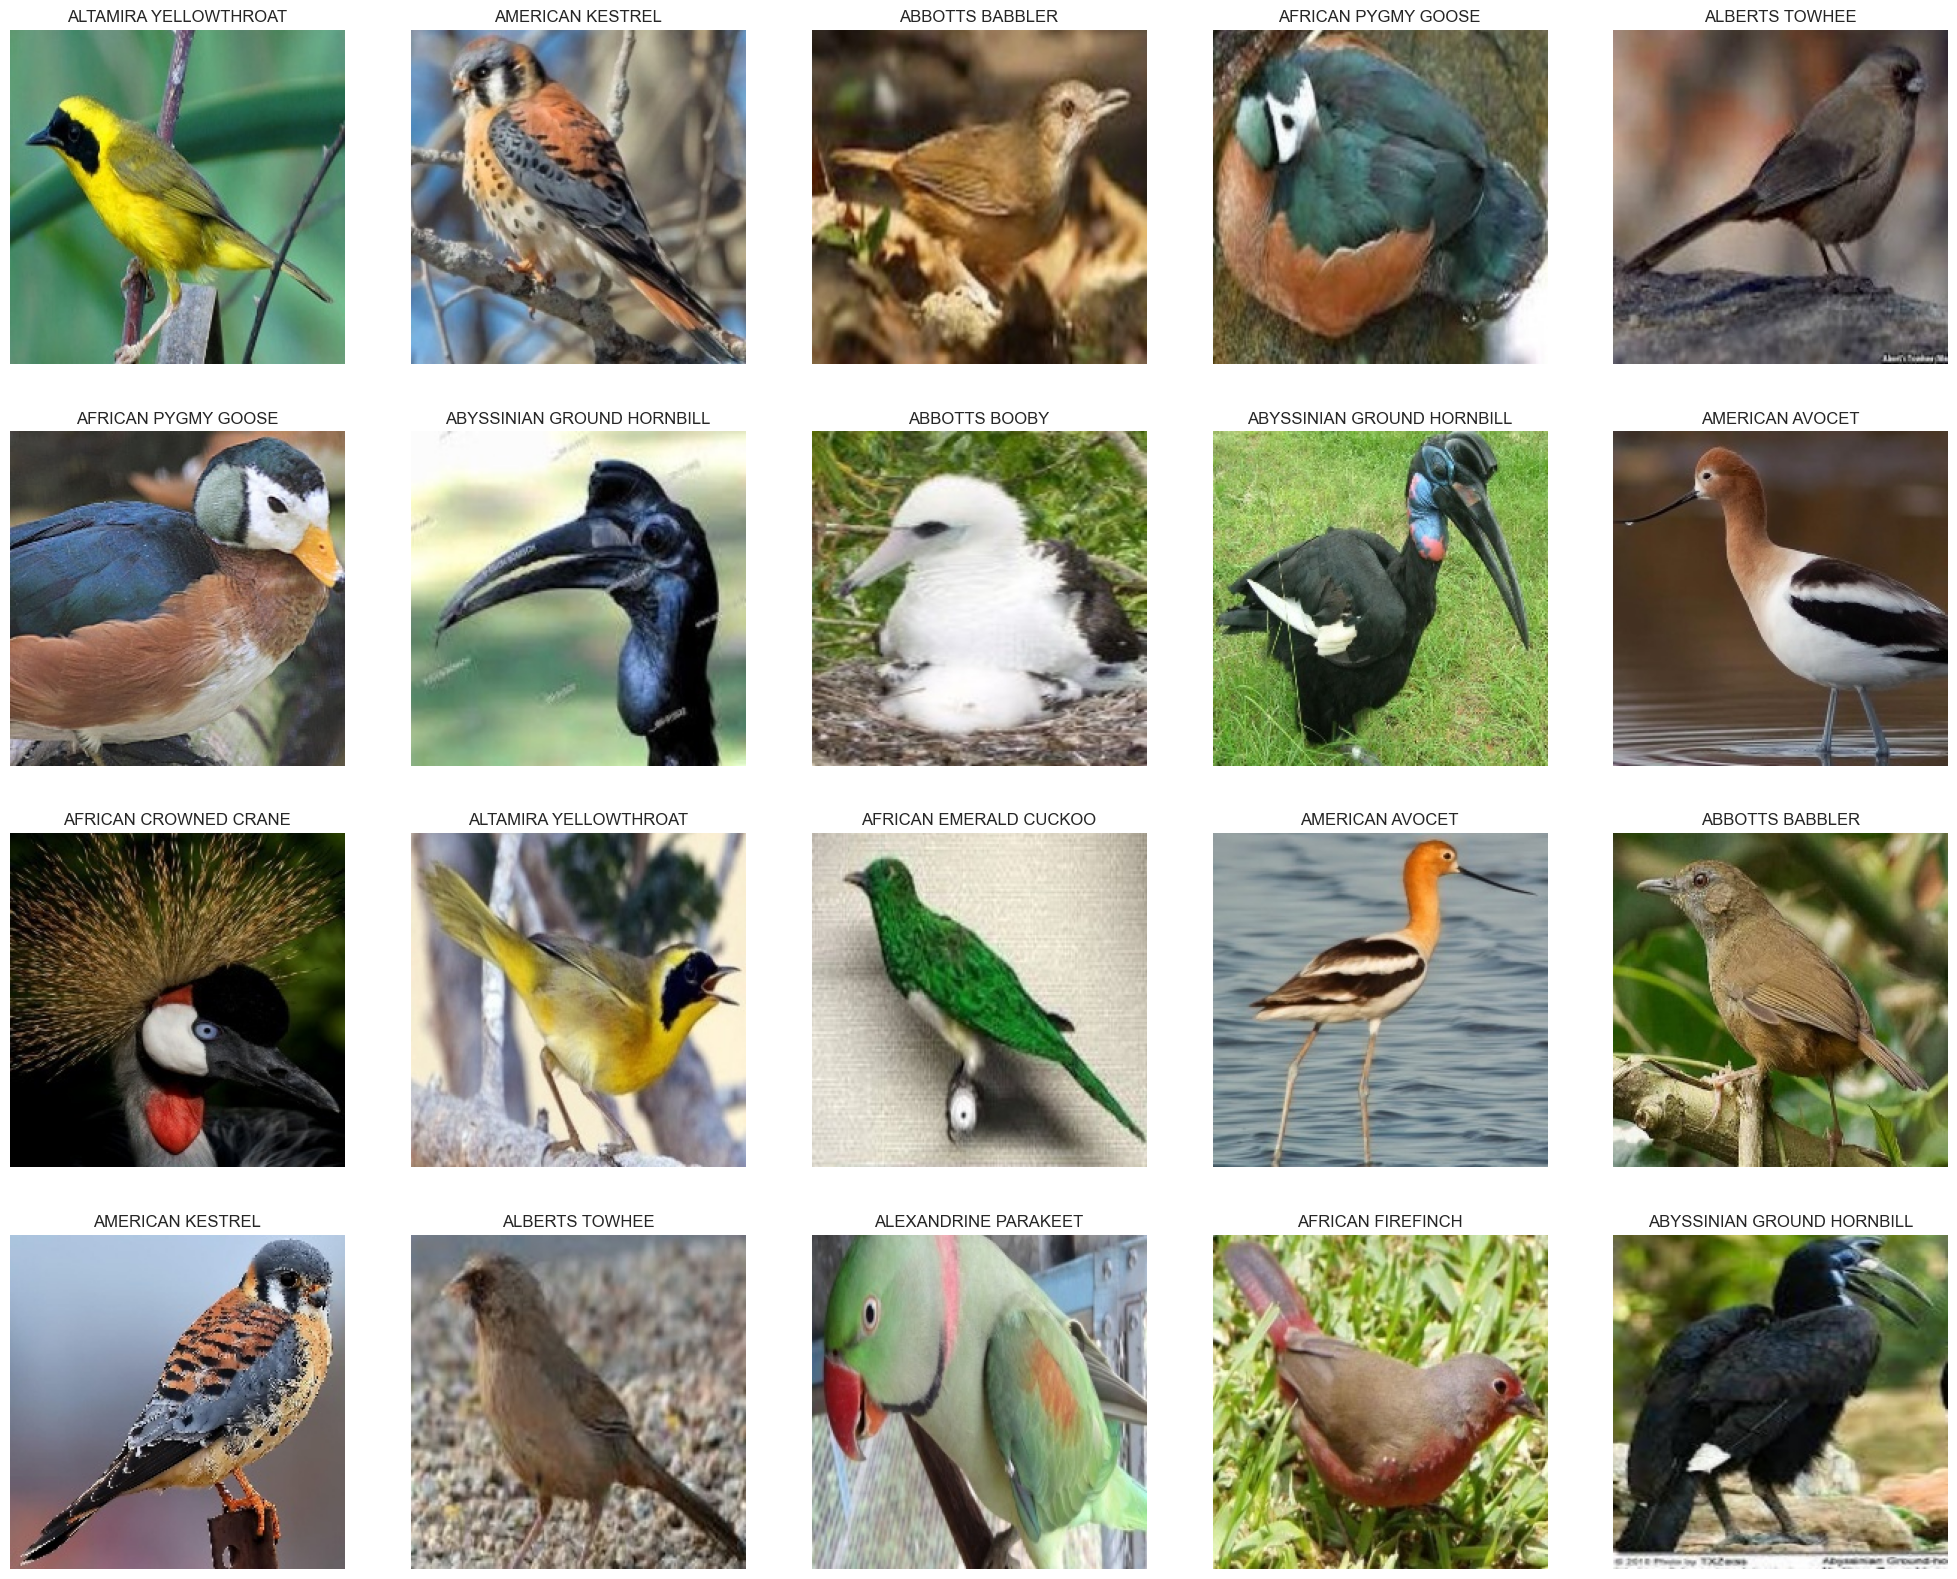

In [337]:
def plot_images(data, num_images=5):
    num_rows = num_images // 5
    num_cols = 5
    plt.figure(figsize=(25, 5 * num_rows))

    for i in range(num_images):
        img_path = data.iloc[i]['filename']
        img = Image.open(img_path)

        plt.subplot(num_rows, num_cols, i + 1)

        plt.imshow(img)
        plt.title(data.iloc[i]['outcome'])
        plt.axis('off')

    plt.show()


plot_images(train_data, num_images=20)

## Dataset Preparation

In [100]:
train_data['outcome'] = train_data['outcome'].astype('category').cat.codes
test_data['outcome'] = test_data['outcome'].astype('category').cat.codes
val_data['outcome'] = val_data['outcome'].astype('category').cat.codes

In [108]:
class BirdDataset:
    def __init__(self, df, train=True):
        self.df = df
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filename']
        img_label = self.df.iloc[idx]['outcome']
        img = Image.open(img_path).convert('RGB')

        train_transform = transforms.Compose([
            transforms.RandomCrop((160, 160)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
            transforms.ToTensor(),
        ])

        test_transform = transforms.Compose([
            transforms.RandomCrop((160, 160)),
            transforms.ToTensor(),
        ])

        output_image = train_transform(img) if self.train else test_transform(img)
        input_image = transforms.Grayscale(num_output_channels=1)(output_image)

        return input_image, output_image, torch.tensor(img_label)


train_dataset = BirdDataset(train_data, train=True)
val_dataset = BirdDataset(val_data, train=False)
test_dataset = BirdDataset(test_data, train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)


## Auto-Encoder Architecture

In [293]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            self.encoder_block(1, 64),
            self.encoder_block(64, 128),
            self.encoder_block(128, 256),
            self.encoder_block(256, 1024)
        )

        self.decoder = nn.Sequential(
            self.decoder_block(1024, 256),
            self.decoder_block(256, 128),
            self.decoder_block(128, 64),
            self.decoder_block(64, 3, True)
        )

    def encoder_block(self, in_c, out_c, maxpool=2):
        layers = [nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1)]
        layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=maxpool, stride=maxpool))
        return nn.Sequential(*layers)

    def decoder_block(self, in_c, out_c, last_layer=False):
        layers = [nn.Upsample(scale_factor=2)]
        layers.append(nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1))
        layers.append(nn.BatchNorm2d(out_c))
        if last_layer:
            layers.append(nn.Sigmoid())
        else:
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training Phase

In [301]:
gc.collect()
torch.cuda.empty_cache()

In [302]:
ae_model = AutoEncoder().to(device)

In [303]:
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
criterion = nn.MSELoss()
num_epochs = 50

In [294]:
def train(model, optimizer, scheduler, criterion, num_epochs, train_loader, val_loader):
    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()

        for image, colored, _ in train_loader:
            image = image.to(device)
            colored = colored.to(device)

            pred = model(image)
            optimizer.zero_grad()

            loss = criterion(pred, colored)

            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for image, colored, _ in val_loader:
                image = image.to(device)
                colored = colored.to(device)

                pred = model(image)

                loss = criterion(pred, colored)

                val_losses.append(loss.item())

        scheduler.step()
        mean_loss = np.mean(epoch_losses)
        val_mean_loss = np.mean(val_losses)
        print(f"EPOCH#{epoch:2d},\t Train_Loss:{mean_loss:8.6f} \t Val_Loss:{val_mean_loss:8.6f}")

In [304]:
train(ae_model, optimizer, scheduler, criterion, num_epochs, train_loader, val_loader)

EPOCH# 0,	 Train_Loss:0.023175 	 Val_Loss:0.021951
EPOCH# 1,	 Train_Loss:0.018343 	 Val_Loss:0.017969
EPOCH# 2,	 Train_Loss:0.016395 	 Val_Loss:0.015405
EPOCH# 3,	 Train_Loss:0.015321 	 Val_Loss:0.014802
EPOCH# 4,	 Train_Loss:0.014727 	 Val_Loss:0.014134
EPOCH# 5,	 Train_Loss:0.013894 	 Val_Loss:0.013249
EPOCH# 6,	 Train_Loss:0.013526 	 Val_Loss:0.017584
EPOCH# 7,	 Train_Loss:0.013261 	 Val_Loss:0.014681
EPOCH# 8,	 Train_Loss:0.012712 	 Val_Loss:0.011953
EPOCH# 9,	 Train_Loss:0.012481 	 Val_Loss:0.012945
EPOCH#10,	 Train_Loss:0.012168 	 Val_Loss:0.012045
EPOCH#11,	 Train_Loss:0.011817 	 Val_Loss:0.014353
EPOCH#12,	 Train_Loss:0.011856 	 Val_Loss:0.011286
EPOCH#13,	 Train_Loss:0.011652 	 Val_Loss:0.012677
EPOCH#14,	 Train_Loss:0.011456 	 Val_Loss:0.011568
EPOCH#15,	 Train_Loss:0.011022 	 Val_Loss:0.010983
EPOCH#16,	 Train_Loss:0.011078 	 Val_Loss:0.011244
EPOCH#17,	 Train_Loss:0.011006 	 Val_Loss:0.012063
EPOCH#18,	 Train_Loss:0.010921 	 Val_Loss:0.011272
EPOCH#19,	 Train_Loss:0.010856 

In [305]:
def plot_outputs(model, val_dataset, num_images):
    model.eval()

    plt.figure(figsize=(20, 5 * num_images))
    for i in range(num_images):
        ori_in, ori_out, _ = val_dataset[i]
        pred_out = model(ori_in.unsqueeze(0).to(device))[0].squeeze(0).clip(0, 1)

        plt.subplot(num_images, 3, 3 * i + 1)
        im = np.repeat(ori_in.numpy().transpose(1, 2, 0), 3, axis=2)
        plt.imshow(im)
        plt.axis('off')
        plt.title('Grayscale Input')

        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(ori_out.numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.title('Actual')

        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(pred_out.detach().cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.title('Predicted')

    plt.show()

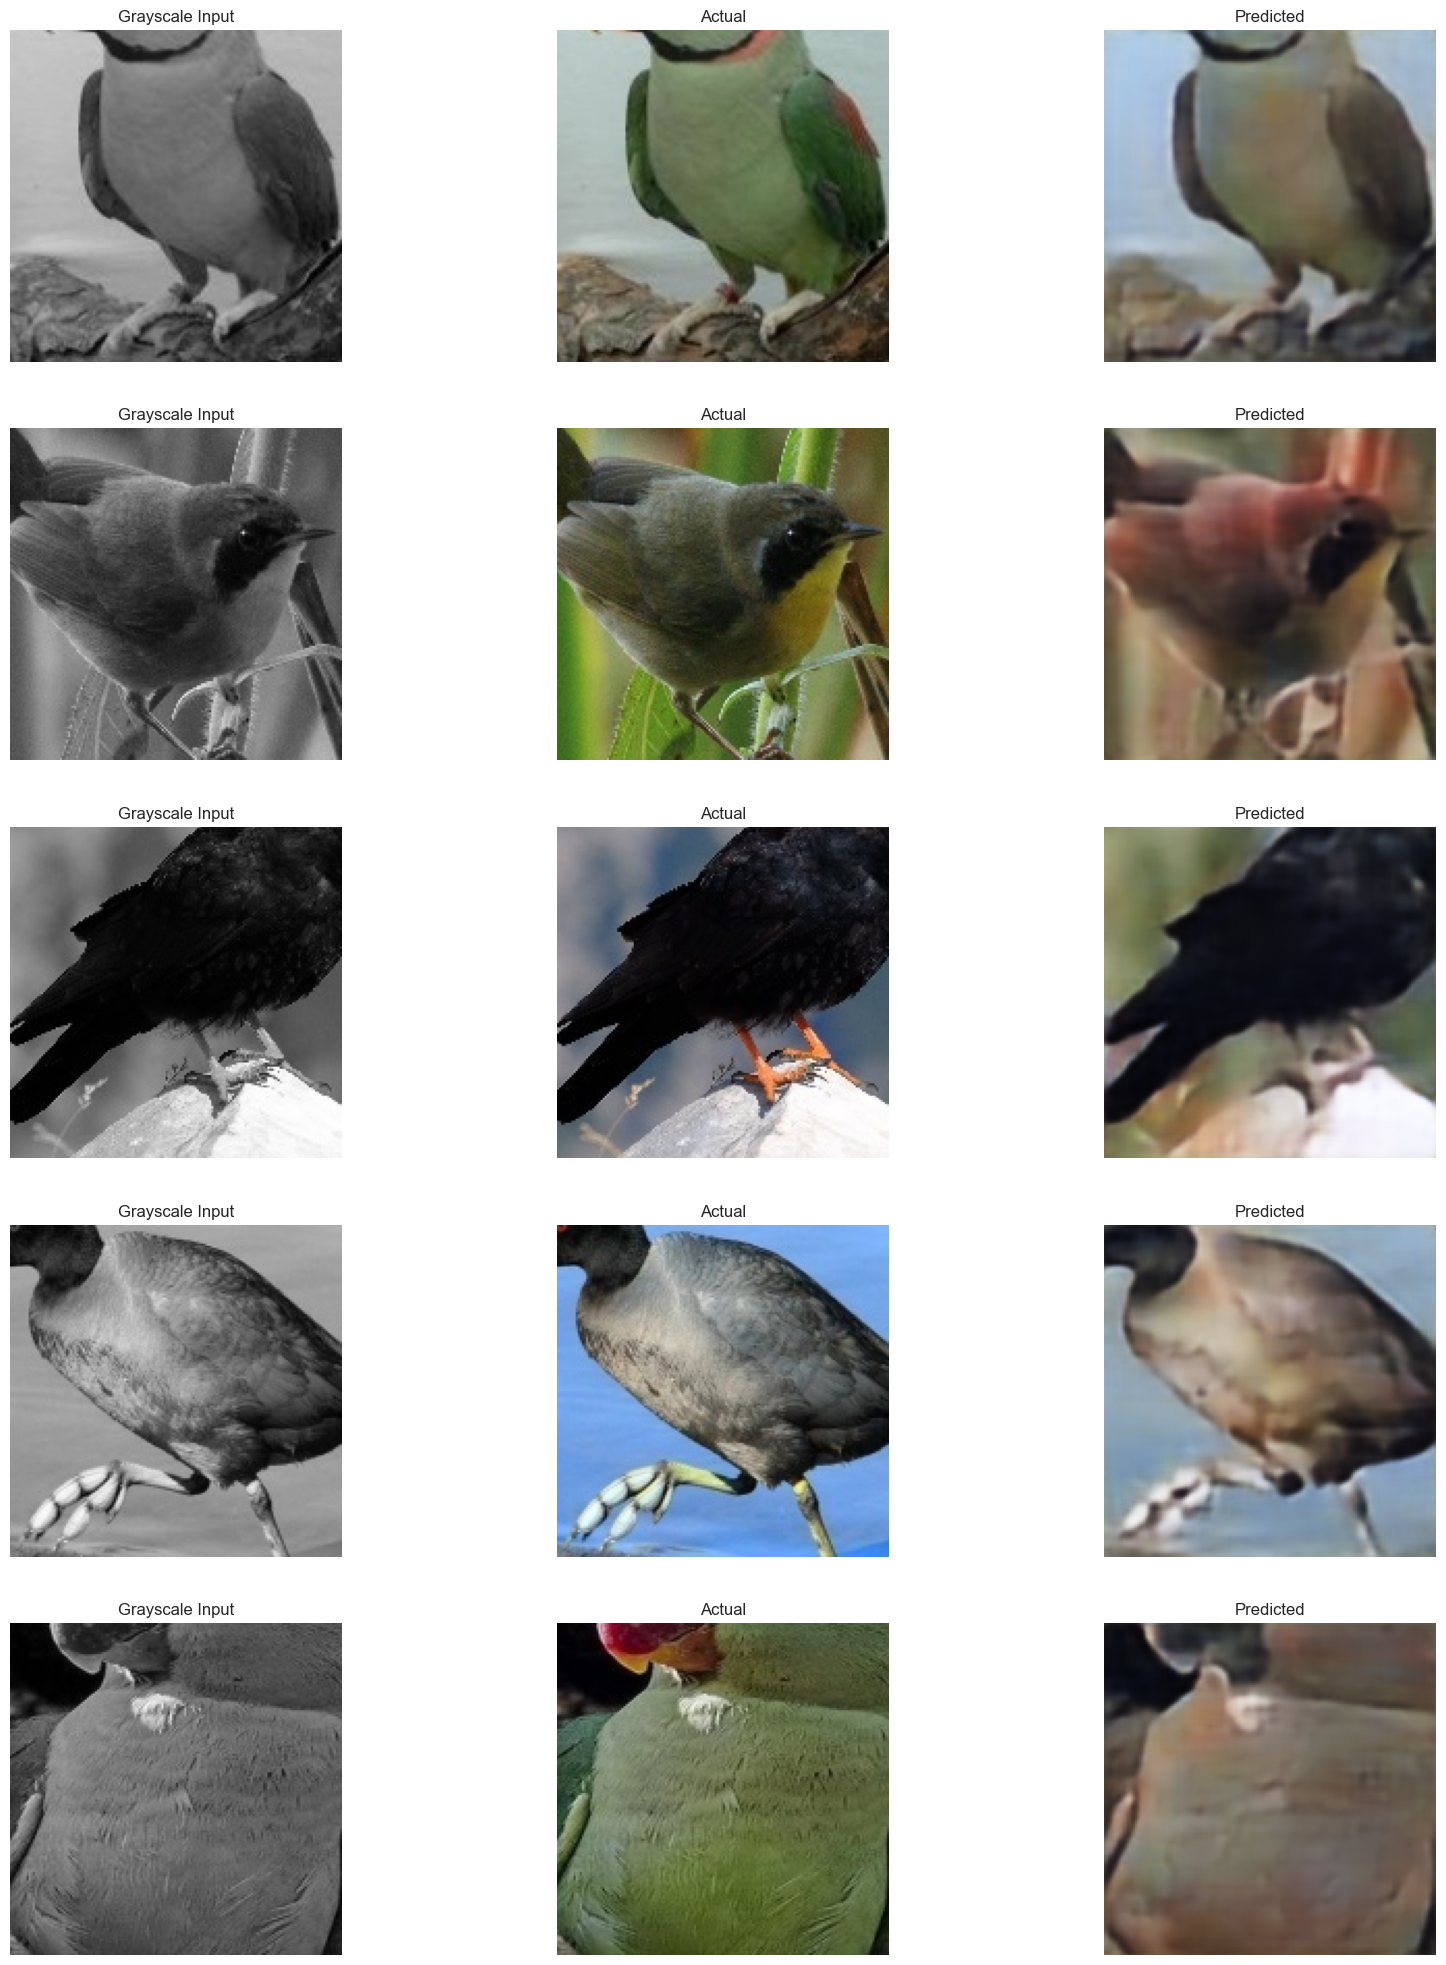

In [306]:
plot_outputs(ae_model, val_dataset, 5)

## Variational Auto-Encoder Architecture

In [324]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            self.encoder_block(1, 64),
            self.encoder_block(64, 128),
            self.encoder_block(128, 256),
            self.encoder_block(256, 1024),
        )

        self.mu_layer = nn.Linear(1024 * 10 * 10, 256)
        self.logvar_layer = nn.Linear(1024 * 10 * 10, 256)

        self.fc = nn.Linear(256, 1024 * 10 * 10)

        self.decoder = nn.Sequential(
            self.decoder_block(1024, 256),
            self.decoder_block(256, 128),
            self.decoder_block(128, 64),
            self.decoder_block(64, 3, True)
        )

    def encoder_block(self, in_c, out_c, maxpool=2):
        layers = [nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1)]
        layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=maxpool, stride=maxpool))
        return nn.Sequential(*layers)

    def decoder_block(self, in_c, out_c, last_layer=False):
        layers = [nn.Upsample(scale_factor=2)]
        layers.append(nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1))
        layers.append(nn.BatchNorm2d(out_c))
        if last_layer:
            layers.append(nn.Sigmoid())
        else:
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc_out = self.encoder(x).view(x.size(0), -1)

        mu = self.mu_layer(enc_out)
        logvar = self.logvar_layer(enc_out)

        z = self.reparameterize(mu, logvar)
        fc_out = self.fc(z).view(x.size(0), 1024, 10, 10)
        dec_out = self.decoder(fc_out)

        return dec_out, mu, logvar

In [325]:
def mse_kl_loss(pred, target, mu, logvar):
    mse = nn.functional.mse_loss(pred, target)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl /= pred.size(0) * pred.numel()

    return mse + kl

## Training Phase

In [326]:
gc.collect()
torch.cuda.empty_cache()

In [327]:
vae_model = VariationalAutoEncoder().to(device)

In [328]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
criterion = mse_kl_loss
num_epochs = 50

In [329]:
def train(model, optimizer, scheduler, criterion, num_epochs, train_loader, val_loader):
    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()

        for image, colored, _ in train_loader:
            image = image.to(device)
            colored = colored.to(device)

            pred, mu, logvar = model(image)
            optimizer.zero_grad()

            loss = criterion(pred, colored, mu, logvar)

            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for image, colored, _ in val_loader:
                image = image.to(device)
                colored = colored.to(device)

                pred, mu, logvar = model(image)
                loss = criterion(pred, colored, mu, logvar)

                val_losses.append(loss.item())

        scheduler.step()
        mean_loss = np.mean(epoch_losses)
        val_mean_loss = np.mean(val_losses)
        print(f"EPOCH#{epoch:2d},\t Train_Loss:{mean_loss:8.6f} \t Val_Loss:{val_mean_loss:8.6f}")

In [332]:
train(vae_model, optimizer, scheduler, criterion, num_epochs, train_loader, val_loader)

EPOCH# 0,	 Train_Loss:0.015952 	 Val_Loss:0.016714
EPOCH# 1,	 Train_Loss:0.015920 	 Val_Loss:0.016310
EPOCH# 2,	 Train_Loss:0.015892 	 Val_Loss:0.016206
EPOCH# 3,	 Train_Loss:0.015807 	 Val_Loss:0.016380
EPOCH# 4,	 Train_Loss:0.015835 	 Val_Loss:0.016379
EPOCH# 5,	 Train_Loss:0.015661 	 Val_Loss:0.016764
EPOCH# 6,	 Train_Loss:0.015874 	 Val_Loss:0.015694
EPOCH# 7,	 Train_Loss:0.015801 	 Val_Loss:0.015864
EPOCH# 8,	 Train_Loss:0.015692 	 Val_Loss:0.016017
EPOCH# 9,	 Train_Loss:0.015681 	 Val_Loss:0.015689
EPOCH#10,	 Train_Loss:0.015541 	 Val_Loss:0.015408
EPOCH#11,	 Train_Loss:0.015533 	 Val_Loss:0.016385
EPOCH#12,	 Train_Loss:0.015537 	 Val_Loss:0.015382
EPOCH#13,	 Train_Loss:0.015516 	 Val_Loss:0.015973
EPOCH#14,	 Train_Loss:0.015498 	 Val_Loss:0.015371
EPOCH#15,	 Train_Loss:0.015377 	 Val_Loss:0.015778
EPOCH#16,	 Train_Loss:0.015314 	 Val_Loss:0.016008
EPOCH#17,	 Train_Loss:0.015476 	 Val_Loss:0.015633
EPOCH#18,	 Train_Loss:0.015411 	 Val_Loss:0.016124
EPOCH#19,	 Train_Loss:0.015196 

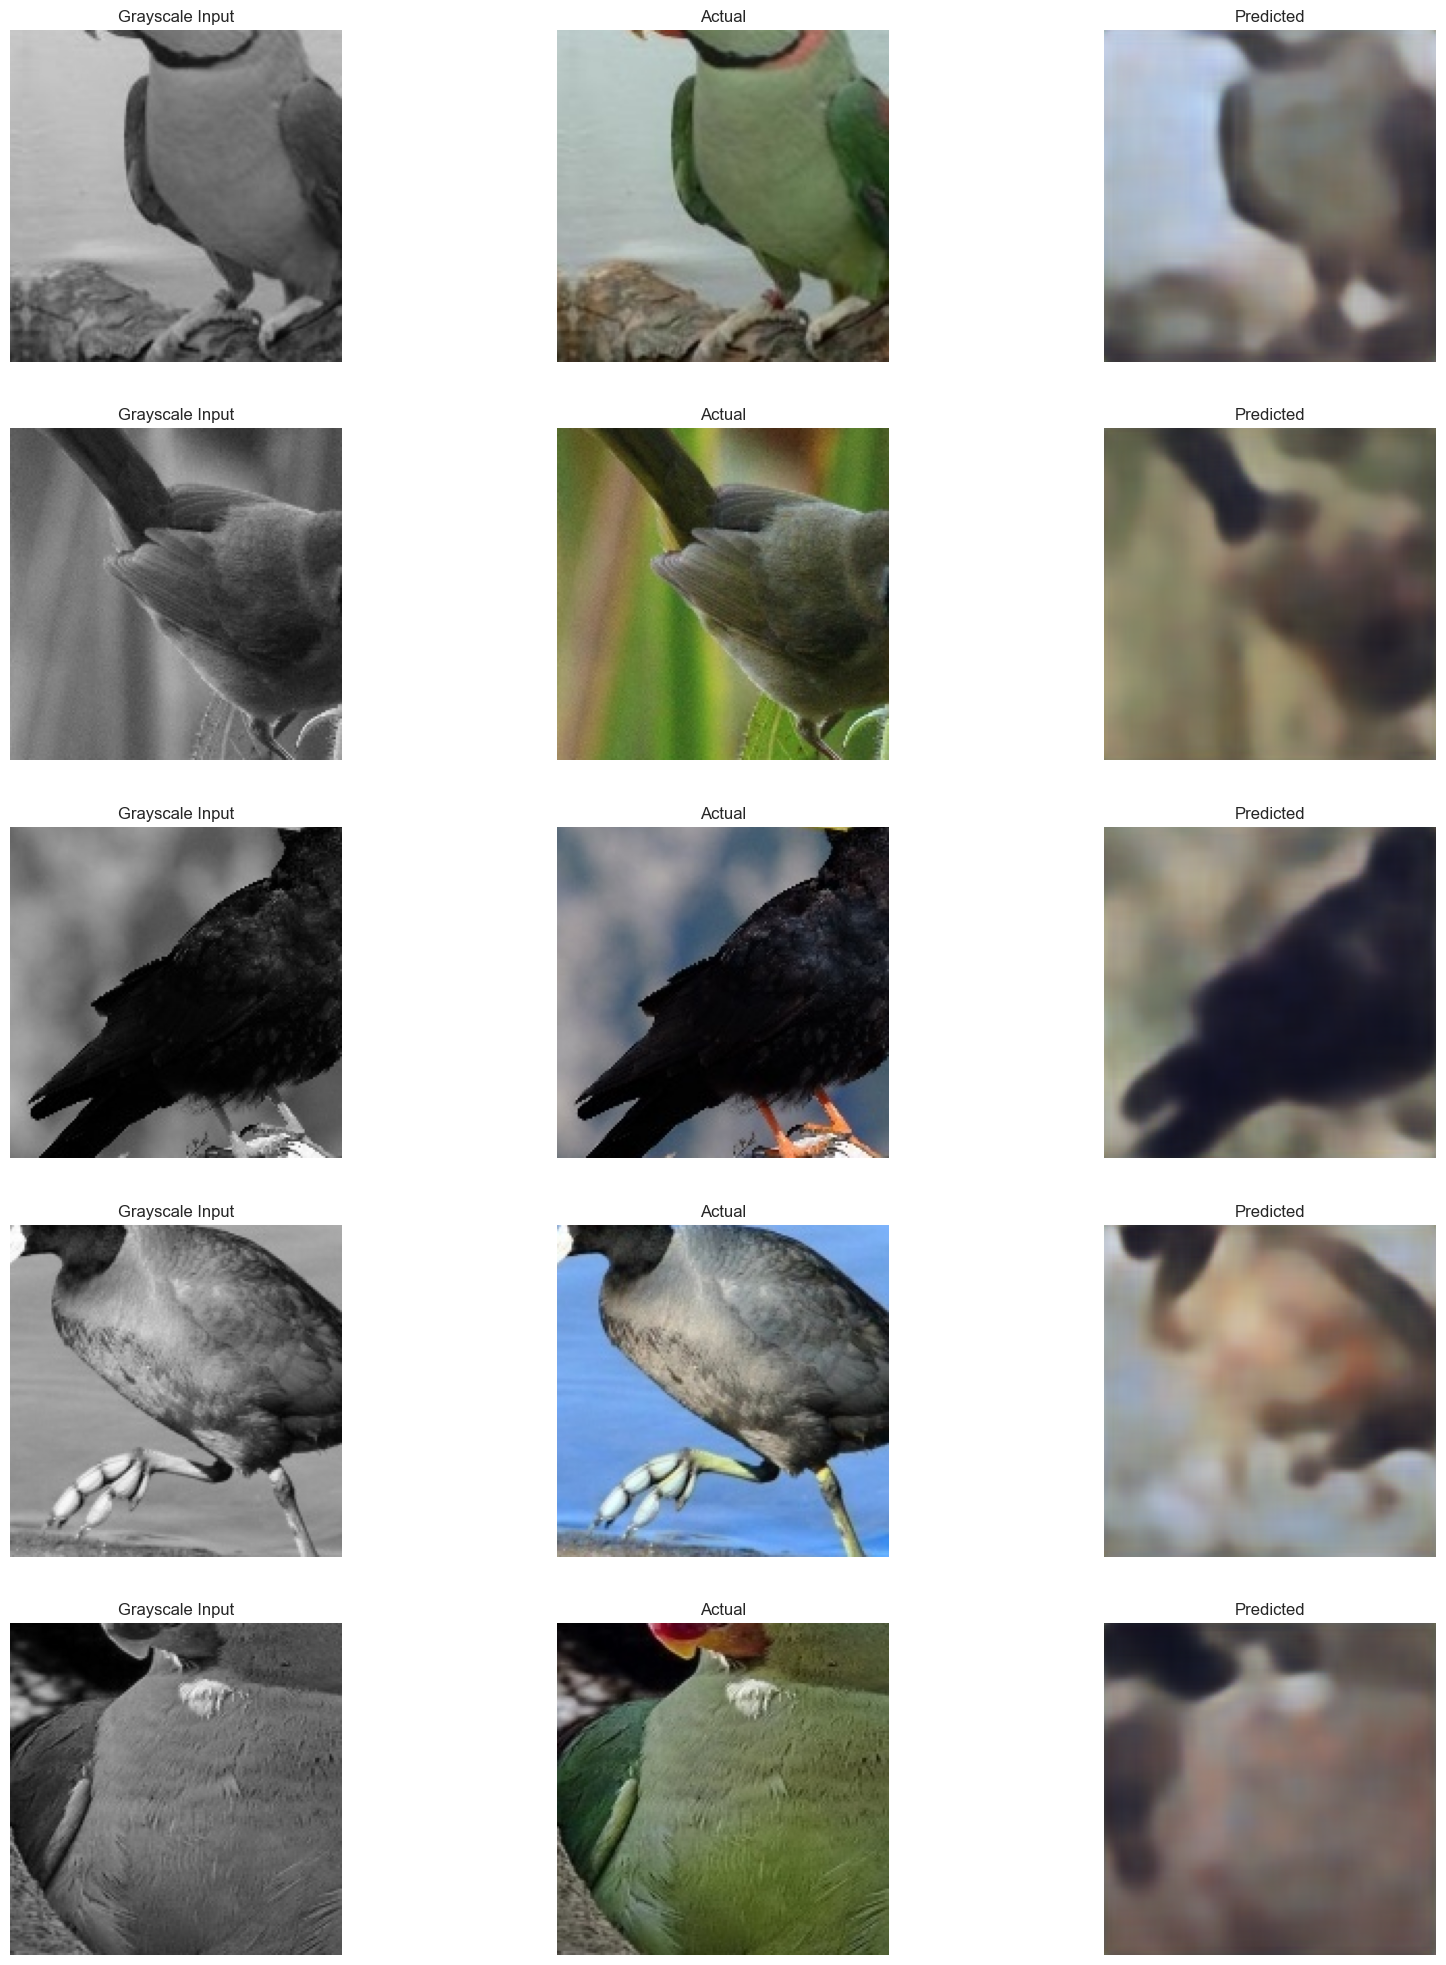

In [333]:
plot_outputs(vae_model, val_dataset, 5)